In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, tilt_distance_LI, robust_smooth, normalize_matrix, calc_ow, fit_psi_params, psi_params, axis_ratio


#### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_IMOS_drifters.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


#### SADCP Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/ESP_Paper_Data/sadcp_data_CCE_2023.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


(np.float64(-150000.0),
 np.float64(150000.0),
 np.float64(-150000.0),
 np.float64(150000.0))

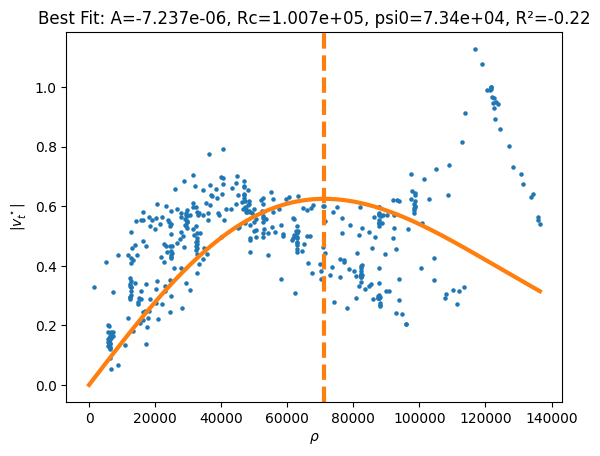

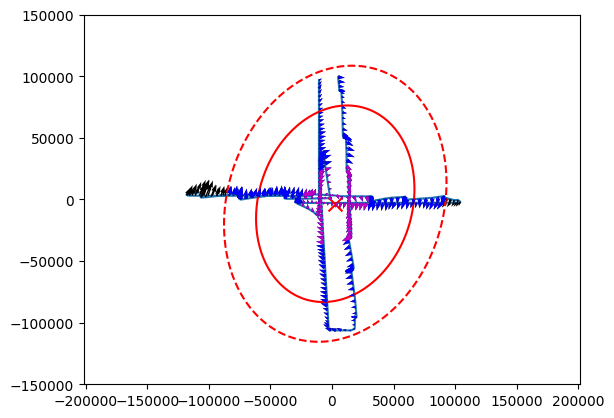

In [4]:
x = np.linspace(-150000, 150000, 101)
y = np.linspace(-150000, 150000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xi, yi, ui, vi = df_sadcp.x,  df_sadcp.y, df_sadcp.u_37, df_sadcp.v_37

xc_0, yc_0, w_0, Q_0, Rc_0, psi0_0, A_0 = espra(xi, yi, ui, vi, plot_flag=True, Rc_max=150000)

plt.figure()
plt.plot(df_sadcp.x, df_sadcp.y)
plt.quiver(xi, yi, ui, vi, zorder=2, scale=40)
plt.scatter(xc_0, yc_0, marker='x', s=100, color='r', zorder=3)

dx_ell, dy_ell = X - xc_0, Y - yc_0
rho2_ell = Q_0[0,0]*dx_ell**2 + 2*Q_0[1,0]*dx_ell*dy_ell + Q_0[1,1]*dy_ell**2
plt.contour(X, Y, rho2_ell, levels=[Rc_0**2/2],
            colors='r')
plt.contour(X, Y, rho2_ell, levels=[100000**2],
            colors='r', linestyles='--')

def masks_from_Q(df, xc, yc, Q, Rc_outer):
    dx, dy = df.x - xc, df.y - yc
    rho2 = Q[0,0]*dx**2 + 2*Q[0,1]*dx*dy + Q[1,1]*dy**2
    return (np.sqrt(rho2) < 30000), (np.sqrt(rho2) < Rc_outer)

core_mask, outer_mask = masks_from_Q(df_sadcp, xc_0, yc_0, Q_0, 100000)

df_core = df_sadcp[core_mask].copy()
df_outer = df_sadcp[outer_mask].copy()
plt.quiver(df_outer.x, df_outer.y, df_outer.u_37, df_outer.v_37, color='b', zorder=4, scale=40)
plt.quiver(df_core.x, df_core.y, df_core.u_37, df_core.v_37, color='m', zorder=4, scale=40)

plt.axis('equal')


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Depth
0,-955.028710,-593.008516,-0.000043,"[[1.2113969427292266, -0.02504785087522949], [...",70710.449751,53282.055144,-0.000011,0.891689,0.603989,37
1,-1630.963428,-389.094626,-0.000043,"[[1.199180991907587, -0.09444900494959498], [-...",66380.204853,49180.778200,-0.000011,0.889891,0.563306,47
2,-1294.082248,52.043796,-0.000043,"[[1.2061595914293095, -0.11622043164249596], [...",65839.667338,48147.322560,-0.000011,0.871525,0.484775,57
3,-704.680856,381.807602,-0.000041,"[[1.184449444341292, -0.11019741588123826], [-...",66590.291567,48291.421692,-0.000011,0.869393,0.510959,67
4,-105.710051,644.852843,-0.000040,"[[1.141812633218801, -0.1022891494720783], [-0...",67466.708221,48380.689972,-0.000011,0.868727,0.514405,77
...,...,...,...,...,...,...,...,...,...,...
62,-525.885422,-724.999366,-0.000029,"[[1.0749741814015137, -0.07210549132440051], [...",67472.258364,36993.094424,-0.000008,0.851377,0.527120,657
63,-196.314618,-852.817411,-0.000030,"[[1.033395964657583, -0.09656259745213967], [-...",68449.617074,37629.608318,-0.000008,0.856483,0.623267,667
64,256.286700,-921.977983,-0.000030,"[[1.002128579875968, -0.10087442087853961], [-...",69262.064921,37849.598322,-0.000008,0.845204,0.581361,677
65,-746.601057,-857.333985,-0.000030,"[[0.9843571076989492, -0.08013280611191734], [...",69419.196884,37798.958825,-0.000008,0.856823,0.704936,687


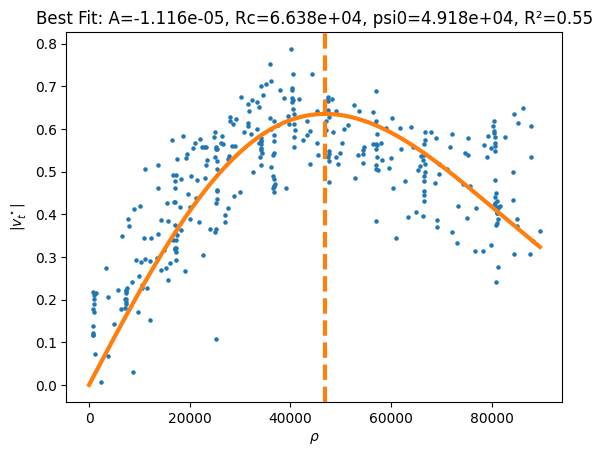

In [5]:
import re

# --- helpers ---
def non_uv_cols(df):
    return [c for c in df.columns if not (c.startswith('u_') or c.startswith('v_'))]

def keep_for_depth(df, d):
    keep = non_uv_cols(df) + [f"u_{d}", f"v_{d}"]
    return df[[c for c in keep if c in df.columns]]

def depth_list(df):
    u = {int(m.group(1)) for c in df.columns if (m := re.fullmatch(r"u_(\d+)", c))}
    v = {int(m.group(1)) for c in df.columns if (m := re.fullmatch(r"v_(\d+)", c))}
    return sorted(u & v)

def masks_from_Q(df, xc, yc, Q, Rc_outer):
    dx, dy = df.x - xc, df.y - yc
    rho2 = Q[0,0]*dx**2 + 2*Q[0,1]*dx*dy + Q[1,1]*dy**2
    ok = rho2 >= 0
    core  = ok & (np.sqrt(rho2) < 30000.0)
    outer = ok & (np.sqrt(rho2) < Rc_outer)
    return core, outer

# --- initialise ---
core_mask, outer_mask = masks_from_Q(df_sadcp, xc_0, yc_0, Q_0, 100000.0)

df_res    = pd.DataFrame(columns=['xc','yc','w','Q','Rc','psi0','A','r2_1','r2_2','Depth'])
dic_depth = {}

depths = [d for d in depth_list(df_sadcp) if d <= 700]
depths = depths[1:] # ignore depth 27

xc_prev, yc_prev, Q_prev = float(xc_0), float(yc_0), Q_0
Rc_outer = 100000.0

for k, d in enumerate(depths):

    df_core  = keep_for_depth(df_sadcp[core_mask].copy(),  d)
    df_outer = keep_for_depth(df_sadcp[outer_mask].copy(), d)

    xi, yi = df_core.x.values, df_core.y.values
    ui, vi = df_core.get(f"u_{d}").values, df_core.get(f"v_{d}").values
    m = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
    xi, yi, ui, vi = xi[m], yi[m], ui[m], vi[m]
    if len(xi) <= 2:
        break

    axi, ayi = df_outer.x.values, df_outer.y.values
    aui, avi = df_outer.get(f"u_{d}").values, df_outer.get(f"v_{d}").values
    ma = ~np.isnan(axi) & ~np.isnan(ayi) & ~np.isnan(aui) & ~np.isnan(avi)
    axi, ayi, aui, avi = axi[ma], ayi[ma], aui[ma], avi[ma]

    # --- ESPRA fit ---
    xc, yc, w, Q, _, _, A0, r2_1, r2_2 = espra(xi, yi, ui, vi, r2_flag=True)

    # STOP if slice fails
    if (np.hypot(xc - xc_prev, yc - yc_prev) >= 100000.0) or (w >= 0.0) or (A0 >= 0.0):
        break

    try:
        dfp = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        dfp = dfp[dfp.vt < 0.0]
        if k == 1:
            dfp_surf = dfp.copy(); A0_surf = A0
        Rc, psi0, A = fit_psi_params(dfp.rho2, dfp.Qr, dfp.vt, A0=A0,
                                     Rc_max=150000, plot=k==1)#(k % 5 == 0))
        if (not np.isfinite(A)) or (A >= 0.0):
            Rc, psi0, A = np.nan, np.nan, A0
    except Exception:
        break  

    df_res.loc[len(df_res)] = dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, A=A,
                                   r2_1=r2_1, r2_2=r2_2, Depth=d)

    dic_depth[f"Depth{d}"] = dict(
        xi=xi, yi=yi, ui=ui, vi=vi,
        df_core=df_core, df_outer_core=df_outer, Depth=d
    )

    # update masks using CURRENT depth → next iteration
    Rc_outer = max(min(1.25*float(Rc), 200000.0), 30000.0) if np.isfinite(Rc) else Rc_outer
    xc_prev, yc_prev, Q_prev = float(xc), float(yc), Q
    core_mask, outer_mask = masks_from_Q(df_sadcp, xc_prev, yc_prev, Q_prev, Rc_outer)

df_res


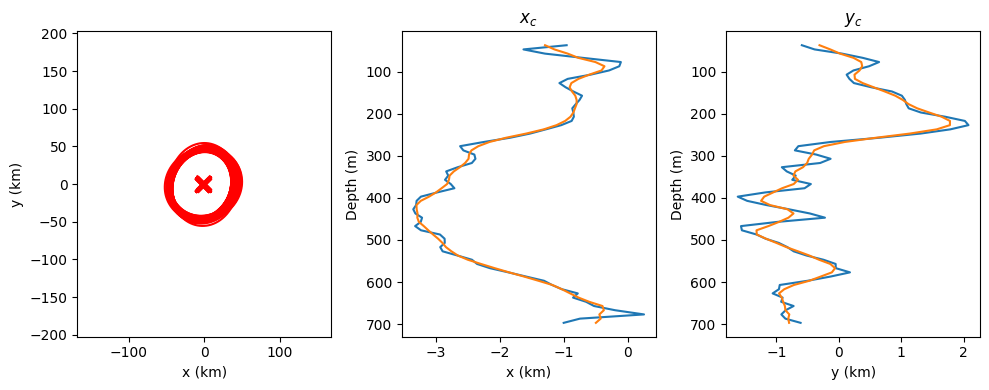

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for k in range(len(df_res)):
    data = df_res.iloc[k]
    axs[0].scatter(data.xc/1e3, data.yc/1e3, marker='x', s=100, color='r', zorder=3)
    dx_ell, dy_ell = X/1e3 - data.xc/1e3, Y/1e3 - data.yc/1e3
    rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[1,0]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
    axs[0].contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.Rc/1e3)**2/2],
                colors='r')
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Depth, window=wdw, num=len(df_res)) 
axs[1].plot(df_res.xc/1e3, df_res.Depth)
axs[1].plot(df_res.sxc/1e3, df_res.Depth)
axs[1].invert_yaxis()
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('Depth (m)'); axs[1].set_title(r'$x_c$')
axs[2].plot(df_res.yc/1e3, df_res.Depth)
axs[2].plot(df_res.syc/1e3, df_res.Depth)
axs[2].invert_yaxis()
axs[2].set_xlabel('y (km)'); axs[2].set_ylabel('Depth (m)'); axs[2].set_title(r'$y_c$')
plt.tight_layout()
                 

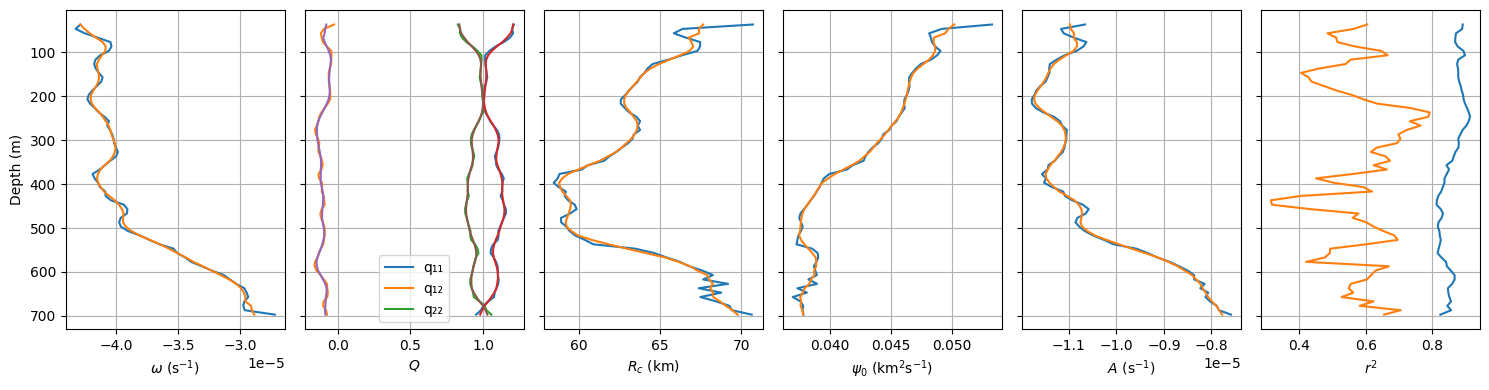

In [7]:
wdw = 5
df_res['sw'] = smooth(df_res.w, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Depth, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 6, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$ (s$^{-1}$)')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Depth)
axs[1].plot(df_res.sq12, df_res.Depth)
axs[1].plot(df_res.sq22, df_res.Depth)
axs[1].set_xlabel(r'$Q$')
axs[1].legend()

axs[2].plot(df_res.Rc/1e3, df_res.Depth)
axs[2].plot(df_res.sRc/1e3, df_res.Depth)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].plot(df_res.psi0/1e6, df_res.Depth)
axs[3].plot(df_res.spsi0/1e6, df_res.Depth)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].plot(df_res.A, df_res.Depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

axs[5].plot(df_res.r2_1, df_res.Depth)
axs[5].plot(df_res.r2_2, df_res.Depth)
axs[5].set_xlabel(r'$r^2$')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()


In [8]:
df_res.sRc.min(), df_res.sRc.max()

(np.float64(58778.63536556065), np.float64(69772.09509132226))

In [9]:
def tilt_distance_LI(x, y, z, zmin=None, zmax=None):
    x, y, z = np.asarray(x), np.asarray(y), np.asarray(z)
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    if zmin is not None: m &= (z >= zmin)
    if zmax is not None: m &= (z <= zmax)
    x, y = x[m], y[m]
    if x.size == 0: return np.nan, np.nan, (np.nan, np.nan)

    TDx = np.nanmax(x) - np.nanmin(x)
    TDy = np.nanmax(y) - np.nanmin(y)
    TD  = np.hypot(TDx, TDy)
    theta_deg = np.degrees(np.arctan2(TDy, TDx))
    return TD, theta_deg, (TDx, TDy)

tilt_distance_LI(df_res.xc, df_res.yc, df_res.Depth)
    

(np.float64(5170.467412173268),
 np.float64(45.67291537988579),
 (np.float64(3612.882338663617), np.float64(3698.7585035141515)))

In [10]:
import pickle
df_res_sat = pd.read_pickle("/srv/scratch/z5297792/MRes_thesis_ESP_application_files/df_res_SAT_DOPIOE.pkl")


In [11]:
data = df_res.iloc[0]
dx, dy = x_ssh - data.sxc, y_ssh - data.syc
rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

u = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
v =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


In [12]:
depth = 37
df_outer_core = dic_depth[f'Depth{depth}']['df_outer_core'].copy()

df_res['Time_min'] = df_outer_core.Time.min()
df_res['Time_max'] = df_outer_core.Time.max()
df_res['Time_mean'] = df_outer_core.Time.mean()
df_res['Data'] = 'SADCP'
df_res['Method'] = 'ESPRA'
df_res


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Depth,...,sq12,sq22,sRc,spsi0,sA,Time_min,Time_max,Time_mean,Data,Method
0,-955.028710,-593.008516,-0.000043,"[[1.2113969427292266, -0.02504785087522949], [...",70710.449751,53282.055144,-0.000011,0.891689,0.603989,37,...,-0.078572,0.835876,67643.440647,50203.385302,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
1,-1630.963428,-389.094626,-0.000043,"[[1.199180991907587, -0.09444900494959498], [-...",66380.204853,49180.778200,-0.000011,0.889891,0.563306,47,...,-0.086479,0.840539,67380.153377,49725.394399,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
2,-1294.082248,52.043796,-0.000043,"[[1.2061595914293095, -0.11622043164249596], [...",65839.667338,48147.322560,-0.000011,0.871525,0.484775,57,...,-0.089641,0.849424,67397.464346,49456.453514,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
3,-704.680856,381.807602,-0.000041,"[[1.184449444341292, -0.11019741588123826], [-...",66590.291567,48291.421692,-0.000011,0.869393,0.510959,67,...,-0.099798,0.869666,66745.819528,48528.306534,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
4,-105.710051,644.852843,-0.000040,"[[1.141812633218801, -0.1022891494720783], [-0...",67466.708221,48380.689972,-0.000011,0.868727,0.514405,77,...,-0.089852,0.893444,66929.790548,48506.971978,-0.000011,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,-525.885422,-724.999366,-0.000029,"[[1.0749741814015137, -0.07210549132440051], [...",67472.258364,36993.094424,-0.000008,0.851377,0.527120,657,...,-0.081962,0.954328,68263.680594,37601.028616,-0.000008,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
63,-196.314618,-852.817411,-0.000030,"[[1.033395964657583, -0.09656259745213967], [-...",68449.617074,37629.608318,-0.000008,0.856483,0.623267,667,...,-0.083572,0.974627,68673.626680,37685.017333,-0.000008,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
64,256.286700,-921.977983,-0.000030,"[[1.002128579875968, -0.10087442087853961], [-...",69262.064921,37849.598322,-0.000008,0.845204,0.581361,677,...,-0.084677,0.999734,69047.632142,37628.083661,-0.000008,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA
65,-746.601057,-857.333985,-0.000030,"[[0.9843571076989492, -0.08013280611191734], [...",69419.196884,37798.958825,-0.000008,0.856823,0.704936,687,...,-0.087820,1.015895,69441.475587,37786.830970,-0.000008,2023-10-17 10:27:31.000004,2023-10-21 22:27:30.333340,2023-10-19 15:05:34.950679808,SADCP,ESPRA


In [13]:
df_res['AR'] = axis_ratio(df_res)


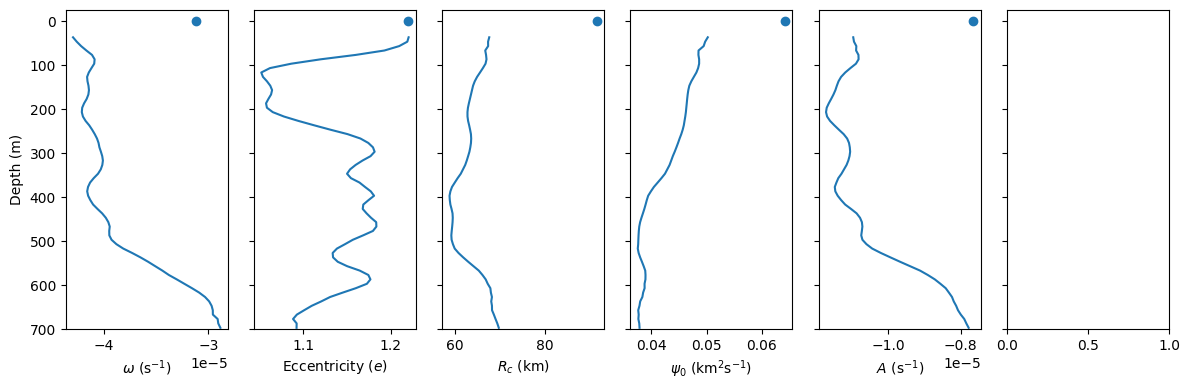

In [14]:
fig, axs = plt.subplots(1, 6, figsize=(12, 4), sharey=True)

t = df_res.Time_mean.iloc[0]
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
if closest in df_res_sat.Time.values:
    data_sat = df_res_sat[df_res_sat.Time==closest].iloc[0]
depth = 0

axs[0].scatter(data_sat.sw, depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$ (s$^{-1}$)')

axs[1].scatter(data_sat.AR, depth)
axs[1].plot(df_res.AR, df_res.Depth)
axs[1].set_xlabel(r'Eccentricity ($e$)')

axs[2].scatter(data_sat.sRc/1e3, depth)
axs[2].plot(df_res.sRc/1e3, df_res.Depth)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].scatter(data_sat.spsi0/1e6, depth)
axs[3].plot(df_res.spsi0/1e6, df_res.Depth)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].scatter(data_sat.sA, depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

# axs[5].scatter(data_sat.r2_1, depth)
# axs[5].scatter(data_sat.r2_2, depth)
# axs[5].plot(df_res.r2_1, df_res.Depth, label='Core')
# axs[5].plot(df_res.r2_2, df_res.Depth, label='Out. Core')
# axs[5].set_xlabel(r'$r^2$')
# axs[5].set_xlim(0, 1)
# axs[5].legend()

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylim(700, -25)
axs[0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


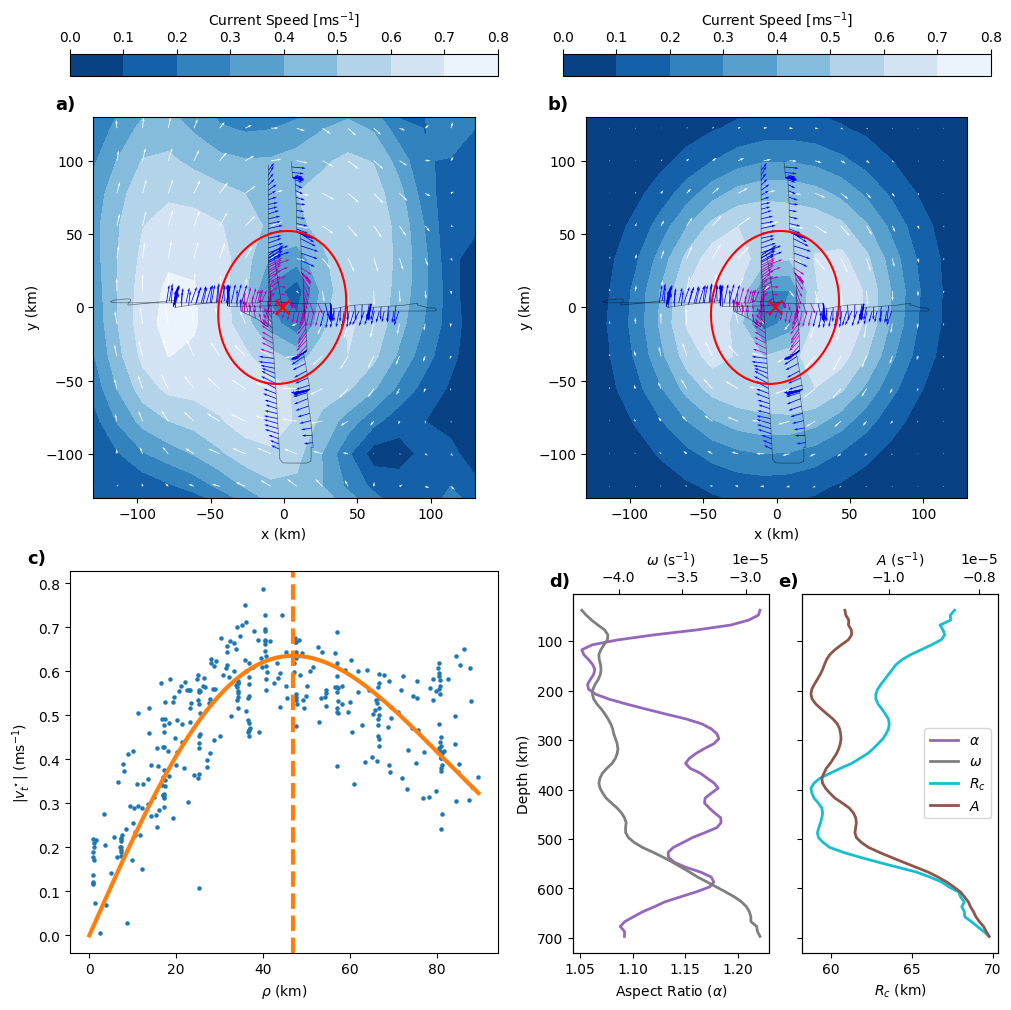

In [16]:
depth = 47
df_outer_core = dic_depth[f'Depth{depth}']['df_outer_core'].copy()
df_core = dic_depth[f'Depth{depth}']['df_core'].copy()
df = df_outer_core.copy()
subset = df_core.copy()
df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')

data = df_res[df_res.Depth == depth].iloc[0]
dxg = x_ssh/1e3 - data.sxc/1e3
dyg = y_ssh/1e3 - data.syc/1e3
rho2g = data.sq11*dxg**2 + 2*data.sq12*dxg*dyg + data.sq22*dyg**2
inside = (x_ssh/1e3 >= X.min()/1e3 - 0) & (x_ssh/1e3 <= X.max()/1e3 + 0) & \
         (y_ssh/1e3 >= Y.min()/1e3 - 0) & (y_ssh/1e3 <= Y.max()/1e3 + 0)

t = df_outer_core.Time.mean()
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
utt, vtt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

Utt = np.where(inside, utt, np.nan)
Vtt = np.where(inside, vtt, np.nan)
u   = np.where(inside, u,   np.nan)
v   = np.where(inside, v,   np.nan)

spac = 1
scale = 15
gap = 20

fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])   # <-- swapped
ax10 = fig.add_subplot(gs[1, 0])   # <-- swapped

sub = gs[1, 1].subgridspec(1, 2, hspace=0)
ax11a = fig.add_subplot(sub[0, 0])
ax11b = fig.add_subplot(sub[0, 1])

# ===================== ax00 (top-left) =====================
cf0 = ax00.contourf(x_ssh/1e3, y_ssh/1e3, np.hypot(Utt, Vtt), cmap='Blues_r')
ax00.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
            Utt[::spac,::spac], Vtt[::spac,::spac], width=.002, scale=scale, color='w')
ax00.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, color='k', lw=.5, alpha=.5)
ax00.quiver(df_diff.x/1e3, df_diff.y/1e3, df_diff[f'u_{depth}_x'], df_diff[f'v_{depth}_x'],
            color='b', scale=scale, width=.002)
ax00.quiver(df_core.x/1e3, df_core.y/1e3, df_core[f'u_{depth}'], df_core[f'v_{depth}'],
            color='m', scale=scale, width=.002)
ax00.scatter(data.sxc/1e3, data.syc/1e3, marker='x', s=100, color='r', zorder=5)

dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
ax00.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r')

# if closest in df_res_sat.Time.values:
#     data_sat = df_res_sat[df_res_sat.Time == closest].iloc[0]
#     ax00.scatter(data_sat.sxc/1e3, data_sat.syc/1e3, marker='x', s=100, color='limegreen', zorder=4)
#     dxs, dys = X/1e3 - data_sat.sxc/1e3, Y/1e3 - data_sat.syc/1e3
#     rho2s = data_sat.sq11*dxs**2 + 2*data_sat.sq12*dxs*dys + data_sat.sq22*dys**2
#     ax00.contour(X/1e3, Y/1e3, rho2s, levels=[(data_sat.sRc/1e3)**2/2], colors='g')

ax00.set_aspect('equal', adjustable='box')
ax00.set_xlim(X.min()/1e3+gap, X.max()/1e3-gap)
ax00.set_ylim(Y.min()/1e3+gap, Y.max()/1e3-gap)
ax00.set_xlabel('x (km)'); ax00.set_ylabel('y (km)')
plt.colorbar(cf0, ax=ax00, location='top', label=r'Current Speed [ms$^{-1}$]')
ax00.text(-0.1, 1.02, 'a)', transform=ax00.transAxes, fontsize=13, fontweight='bold')

# ===================== ax10 (top-right — previously ax01) =====================
fit_psi_params(
    dfp_surf.rho2/1e6,
    dfp_surf.Qr/1e3,
    dfp_surf.vt,
    A0=A0_surf,
    Rc_max=150000,
    ax=ax10,
    plot=True
)
ax10.set_ylabel(r'$|v_t^\star|$ (ms$^{-1}$)')
ax10.set_xlabel(r'$\rho$ (km)'); ax10.set_title('')
ax10.text(-0.1, 1.02, 'c)', transform=ax10.transAxes, fontsize=13, fontweight='bold')

# ===================== ax01 (bottom-left — previously ax10) =====================
cf1 = ax01.contourf(x_ssh/1e3, y_ssh/1e3, np.hypot(u, v), cmap='Blues_r')
ax01.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
            u[::spac,::spac], v[::spac,::spac], width=.002, scale=scale, color='w')
ax01.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, color='k', lw=.5, alpha=.5)
ax01.quiver(df_diff.x/1e3, df_diff.y/1e3, df_diff[f'u_{depth}_x'], df_diff[f'v_{depth}_x'],
            color='b', scale=scale, width=.002)
ax01.quiver(df_core.x/1e3, df_core.y/1e3, df_core[f'u_{depth}'], df_core[f'v_{depth}'],
            color='m', scale=scale, width=.002)
ax01.scatter(data.sxc/1e3, data.syc/1e3, marker='x', s=100, color='r', zorder=5)
ax01.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r')

ax01.set_aspect('equal', adjustable='box')
ax01.set_xlim(X.min()/1e3+gap, X.max()/1e3-gap)
ax01.set_ylim(Y.min()/1e3+gap, Y.max()/1e3-gap)
ax01.set_xlabel('x (km)'); ax01.set_ylabel('y (km)')
plt.colorbar(cf1, ax=ax01, location='top', label=r'Current Speed [ms$^{-1}$]')
ax01.text(-0.1, 1.02, 'b)', transform=ax01.transAxes, fontsize=13, fontweight='bold')

# ===================== Depth parameter plots (bottom-right cell) =====================
lw = 2
ax1_bottom = ax11a
ax1_top = ax1_bottom.twiny()
ax1_bottom.plot(df_res.AR, df_res.Depth, color='tab:purple', lw=lw)
ax1_top.plot(df_res.sw, df_res.Depth, color='tab:gray', lw=lw)
ax1_bottom.set_xlabel( r'Aspect Ratio ($\alpha$)')
ax1_top.set_xlabel(r'$\omega$ (s$^{-1}$)')
ax11a.set_ylabel('Depth (km)'); #ax1_top.legend(); ax1_bottom.legend();
ax1_bottom.invert_yaxis()
ax11a.text(-0.12, 1.02, 'd)', transform=ax11a.transAxes, fontsize=13, fontweight='bold')

ax2_bottom = ax11b
ax2_top = ax2_bottom.twiny()
ax2_bottom.plot(df_res.sRc/1e3, df_res.Depth, color='tab:cyan', lw=lw)
ax2_top.plot(df_res.sA, df_res.Depth, color='tab:brown', lw=lw)
ax2_bottom.set_xlabel(r'$R_c$ (km)')
ax2_top.set_xlabel(r'$A$ (s$^{-1}$)')
# ax11b.set_ylabel('Depth (km
ax11b.set_yticklabels([]); 
ax11b.plot(np.nan, np.nan, label=r'$\alpha$', c='tab:purple', lw=lw)
ax11b.plot(np.nan, np.nan, label=r'$\omega$', c='tab:gray', lw=lw)
ax11b.plot(np.nan, np.nan, label=r'$R_c$', c='tab:cyan', lw=lw)
ax11b.plot(np.nan, np.nan, label=r'$A$', c='tab:brown', lw=lw)


ax11b.legend(loc='center right')
ax2_bottom.invert_yaxis()
ax11b.text(-0.12, 1.02, 'e)', transform=ax11b.transAxes, fontsize=13, fontweight='bold')

plt.show()

In [17]:
df_res.to_pickle("/srv/scratch/z5297792/MRes_thesis_ESP_application_files/df_res_SADCP_ESPRA.pkl")


In [18]:
U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

    OW[:,:,k] = calc_ow(U[:,:,k].T, V[:,:,k].T, x[1]-x[0], y[1]-y[0])
OW = normalize_matrix(OW)


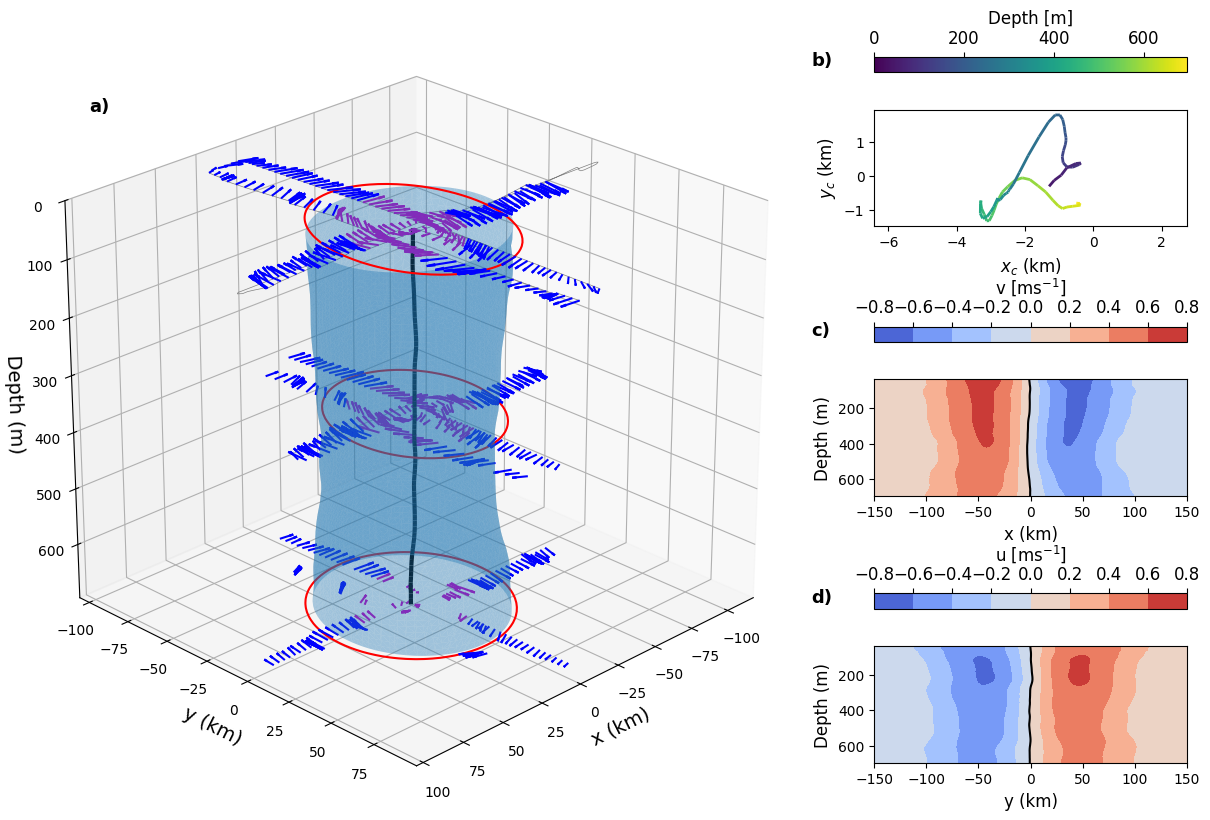

In [19]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import art3d

z = df_res.Depth.values
dz = z[1] - z[0]
dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3

verts, faces, normals, values = measure.marching_cubes(OW, level=-0.2, spacing=(dx, dy, dz))
verts[:,0] += X.min()/1e3
verts[:,1] += Y.min()/1e3
verts[:,2] += z.min()

fig = plt.figure(figsize=(12,8), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.0)

# --- 3D PLOT (left side) ---
ax3d = fig.add_subplot(gs[:, :2], projection='3d')

mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
mesh.set_zsort('min')
ax3d.add_collection3d(mesh)

ax3d.set_xlim(df_sadcp.x.min()/1e3, df_sadcp.x.max()/1e3)
ax3d.set_ylim(df_sadcp.y.min()/1e3, df_sadcp.y.max()/1e3)
ax3d.set_zlim(0, z.max())

# -- Center Line -- 
# ax3d.plot(df_res.sxc/1e3, df_res.syc/1e3, df_res.Depth, color='k', lw=3, label='Center Line')
cx = df_res.sxc.values/1e3
cy = df_res.syc.values/1e3
cz = df_res.Depth.values
pts = np.column_stack([cx, cy, cz])
segs = np.stack([pts[:-1], pts[1:]], axis=1)  # (n-1, 2, 3)
lc = art3d.Line3DCollection(segs, colors='k', linewidths=3)
ax3d.add_collection3d(lc)
# 

ax3d.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, [37]*len(df_sadcp), lw=.5, color='grey')

for depth in [37, 357, 697]:

    df_outer_core = dic_depth[f'Depth{depth}']['df_outer_core'].copy()
    df_core = dic_depth[f'Depth{depth}']['df_core'].copy()
    df = df_outer_core.copy()
    subset = df_core.copy()
    df_diff = df.merge(subset, on=['x', 'y'], how='left', indicator=True)
    df_diff = df_diff[df_diff['_merge'] == 'left_only'].drop(columns='_merge')

    # --- Quiver: Difference velocities ---
    ax3d.quiver(df_diff.x/1e3, df_diff.y/1e3, [depth]*len(df_diff),
                df_diff[f'u_{depth}_x'], df_diff[f'v_{depth}_x'], [0]*len(df_diff),
                color='b', length=20, label='Surface Core ADCP Data')
    # --- Quiver: Core SADCP velocities ---
    ax3d.quiver(df_core.x/1e3, df_core.y/1e3, [depth]*len(df_core),
                df_core[f'u_{depth}'], df_core[f'v_{depth}'], [0]*len(df_core),
                color='m', length=20, label='Surface Outer Core ADCP Data')
    # --- Ellipse contour at this depth ---
    surf_data = df_res[df_res.Depth == depth].iloc[0]
    dx_ell = X/1e3 - surf_data.sxc/1e3
    dy_ell = Y/1e3 - surf_data.syc/1e3
    rho2_ell = surf_data.sq11*dx_ell**2 + 2*surf_data.sq12*dx_ell*dy_ell + surf_data.sq22*dy_ell**2
    ax3d.contour(X/1e3, Y/1e3, rho2_ell, levels=[(surf_data.sRc/1e3)**2/2],
                 colors='r', zdir='z', offset=depth)
# Add a legend entry for the contour
ax3d.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')

ax3d.invert_zaxis()
ax3d.set_box_aspect((.1, .1, .09))
ax3d.view_init(elev=25, azim=45)
ax3d.set_xlabel('x (km)', fontsize=14)
ax3d.set_ylabel('y (km)', fontsize=14)
ax3d.set_zlabel('Depth (m)', fontsize=14)
ax3d.text2D(.1, .9, 'a)', transform=ax3d.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- RIGHT SIDE (3×1 STACKED PLOTS) ---
gs_right = gs[:, 2].subgridspec(3, 1, hspace=0)
ax_xy = fig.add_subplot(gs_right[0, 0])
ax_v  = fig.add_subplot(gs_right[1, 0])
ax_u  = fig.add_subplot(gs_right[2, 0])

# (1) XY Depth Track (LineCollection)
df = df_res.copy().iloc[::-1]
points = np.array([df.sxc, df.syc]).T.reshape(-1, 1, 2)/1e3
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, df.Depth.max()))
lc.set_array(df.Depth)
lc.set_linewidth(2)
ax_xy.add_collection(lc)
ax_xy.autoscale()
ax_xy.axis('equal')
cb = fig.colorbar(lc, ax=ax_xy, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label='Depth [m]', fontsize=12)
ax_xy.set_xlabel(r'$x_c$ (km)', fontsize=12)
ax_xy.set_ylabel(r'$y_c$ (km)', fontsize=12)
ax_xy.text(-0.2, 1.5, 'b)', transform=ax_xy.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# (2) Meridional (v)
xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = ax_v.contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
ax_v.plot(df_res.sxc/1e3, df_res.Depth, color='k')
ax_v.invert_yaxis()
cb = fig.colorbar(c1, ax=ax_v, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
# ax_v.set_title(r'v [ms$^{-1}$]', fontsize=12)
ax_v.set_xlabel('x (km)', fontsize=12)
ax_v.set_ylabel('Depth (m)', fontsize=12)
ax_v.text(-0.2, 1.5, 'c)', transform=ax_v.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# (3) Zonal (u)
c2 = ax_u.contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T, cmap='coolwarm')
ax_u.plot(df_res.syc/1e3, df_res.Depth, color='k')
ax_u.invert_yaxis()
cb = fig.colorbar(c2, ax=ax_u, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)
# ax_u.set_title(r'u [ms$^{-1}$]', fontsize=12)
ax_u.set_xlabel('y (km)', fontsize=12)
ax_u.set_ylabel('Depth (m)', fontsize=12)
ax_u.text(-0.2, 1.5, 'd)', transform=ax_u.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.show()
